# WGCNA Analysis of Genes by Diagnosis

**Created**: 27 October 2021

## Environment

In [1]:
if (!requireNamespace("patchwork")) {
    install.packages("devtools")
    devtools::install_github("thomasp85/patchwork")
}

if (!requireNamespace("BiocManager")) {
    install.packages("BiocManager")
}

if (!requireNamespace("WGCNA")) {
    BiocManager::install("WGCNA")
}

Loading required namespace: patchwork

Loading required namespace: BiocManager

Loading required namespace: WGCNA





In [2]:
library(WGCNA)
library(tidyverse)
library(RColorBrewer)
library(patchwork)

options(stringsAsFactors = FALSE)

setwd("~/eQTL_pQTL_Characterization/")

source("04_Expression/scripts/utils/ggplot_theme.R")

Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust



Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor


── Attaching packages ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



## Load Data

In [3]:
gene.exp <- read.table("/lustre/scratch119/humgen/projects/gains_team282/eqtl/data/logcpm_864_20412_hla.txt")
gene.exp <- as.data.frame(t(gene.exp))
ga.prefix.filter <- grepl("GA", rownames(gene.exp))
rownames(gene.exp)[ga.prefix.filter] <- gsub("^GA", "", rownames(gene.exp)[ga.prefix.filter])

sample.info <- read.table("/nfs/team282/data/gains_team282/Sample_info_864.txt")
ga.prefix.filter <- grepl("GA", sample.info$supplier_name)
sample.info$supplier_name[ga.prefix.filter] <- gsub("^GA", "", sample.info$supplier_name[ga.prefix.filter])
sample.info <- sample.info %>% 
  dplyr::filter(supplier_name %in% rownames(gene.exp))
rownames(sample.info) <- sample.info$supplier_name
sample.info <- sample.info[rownames(gene.exp),]

outcome <- read.table("/nfs/team282/data/gains_team282/ClinicalData/clinical_data_tsv/OUT_12jun2019.tsv", sep="\t", header=T, quote="")
outcome <- outcome %>%
  dplyr::mutate(GAinSID=stringr::str_to_upper(SubjectBarCode))
ga.prefix.filter <- grepl("GA", outcome$GAinSID)
outcome$GAinSID[ga.prefix.filter] <- gsub("^GA", "", outcome$GAinSID[ga.prefix.filter])
outcome <- merge(sample.info, outcome, by="GAinSID", all.x=TRUE)
rownames(outcome) <- outcome$supplier_name
outcome <- outcome[sample.info$supplier_name,]
outcome$diagnosis <- replace(outcome$diagnosis, is.na(outcome$diagnosis), 0)

gene.exp.cap <- gene.exp[outcome$diagnosis == 1,]
gene.exp.fp <- gene.exp[outcome$diagnosis == 2,]

sample.info.cap <- sample.info[outcome$diagnosis == 1,]
sample.info.fp <- sample.info[outcome$diagnosis == 2,]

rm(gene.exp, sample.info)

## CAP Individuals

The following analysis generates co-expression modules from gene expression from individuals with community-acquired pneuomnia (CAP).

### WGCNA Checks

The following function identifies genes with excessive missing values and outlier samples. It is generally more important for microarray data.

In [42]:
gsg <- goodSamplesGenes(gene.exp.cap)
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

### Soft Threshold

The adjacency matrix generated using the correlation function does not fit a scale-free topology. A scaling function is used to generate the appropriate gene degree distribution. A parameter of this scaling function, $\beta$, is estimated by trying multiple values and checking how well the resulting network fits the assumptions of a scale-free network. Here, I try all integer values in $[1,20]$.

In [43]:
powers = seq(1, 20, by=1)

# Warning being suppressed - Pearson fallback used when MAD is zero in bicor
soft.thresholds = suppressWarnings(
    pickSoftThreshold(gene.exp.cap, powerVector=powers, networkType="unsigned", corFnc=bicor)
)
    
soft.threshold.cap = soft.thresholds$powerEstimate

   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.162  0.542          0.876 3890.00  3.87e+03 7050.0
2      2    0.483 -0.772          0.795 1270.00  1.10e+03 3540.0
3      3    0.674 -1.160          0.843  548.00  3.84e+02 2120.0
4      4    0.745 -1.320          0.892  278.00  1.62e+02 1400.0
5      5    0.795 -1.380          0.935  157.00  7.27e+01  988.0
6      6    0.810 -1.460          0.952   95.70  3.50e+01  735.0
7      7    0.813 -1.520          0.961   61.80  1.80e+01  568.0
8      8    0.831 -1.550          0.975   41.80  9.62e+00  449.0
9      9    0.842 -1.570          0.983   29.30  5.30e+00  362.0
10    10    0.851 -1.590          0.986   21.10  2.97e+00  296.0
11    11    0.847 -1.610          0.985   15.60  1.71e+00  245.0
12    12    0.847 -1.610          0.985   11.80  1.01e+00  205.0
13    13    0.850 -1.610          0.984    9.12  6.00e-01  173.0
14    14    0.852 -1.600          0.982    7.15  3.68e-01  147.0
15    15    0.861 -1.570 

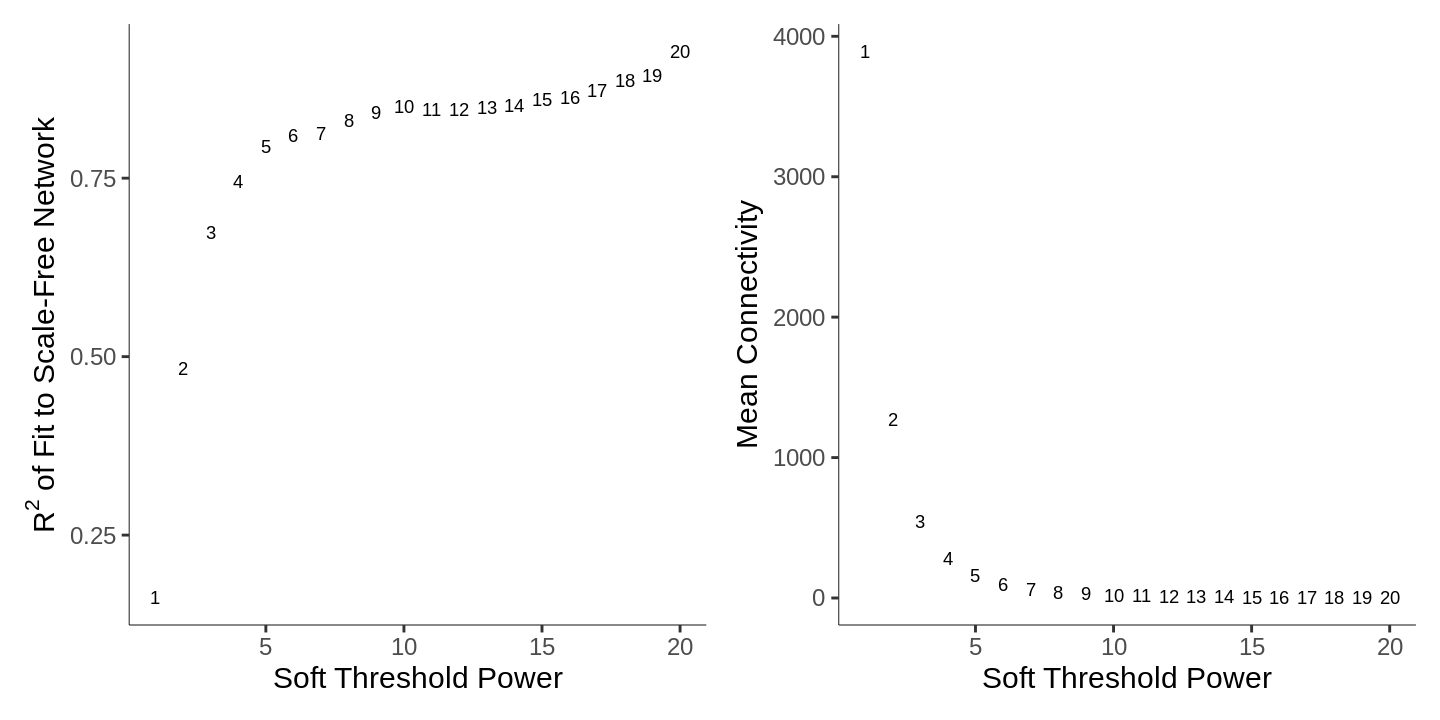

In [44]:
options(repr.plot.width=12, repr.plot.height=6)

p1 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=SFT.R.sq, label=Power)) +
    xlab("Soft Threshold Power") + ylab(bquote(R^2*" of Fit to Scale-Free Network")) +
    ggplot_theme

p2 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=mean.k., label=Power)) +
    xlab("Soft Threshold Power") + ylab("Mean Connectivity") +
    ggplot_theme

p1 + p2

In [45]:
print(soft.threshold.cap)

[1] 10


### Adjacency and TOM Matrices

The adjacency matrix defines the similarity between all genes in the sample data. I am using the [biweight midcorrelation](https://en.wikipedia.org/wiki/Biweight_midcorrelation) (`bicor`) function to estimate similarity. It is a median-based approach that is less sensitive to outliers.

I use $\beta=10$ for the scaling function, which was determined in the previous step. Then, the topological overlap metric (TOM) matrix is generated from the adjacency matrix. For details, check the original WGCNA paper.

In [46]:
adjacency.matrix = adjacency(
    gene.exp.cap, type="unsigned", 
    corFnc=bicor, corOptions=list(use="pairwise.complete.obs", pearsonFallback="individual"), 
    power=soft.threshold.cap
)

TOM.cap.matrix = TOMsimilarity(adjacency.matrix)

dir.create("~/gains_team282/nikhil/expression/gene_expression/", recursive=TRUE)
saveRDS(TOM.cap.matrix, file="~/gains_team282/nikhil/expression/gene_expression/TOM.cap.matrix.RDS")

TOM.cap.dist = 1 - TOM.cap.matrix

Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


Warning message in dir.create("~/gains_team282/nikhil/expression/gene_expression/", :
“'/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression' already exists”


### Clustering TOM Matrix

The gene co-expression modules are generated by clustering the TOM matrix.

 ..cutHeight not given, setting it to 0.999  ===>  99% of the (truncated) height range in dendro.
 ..done.


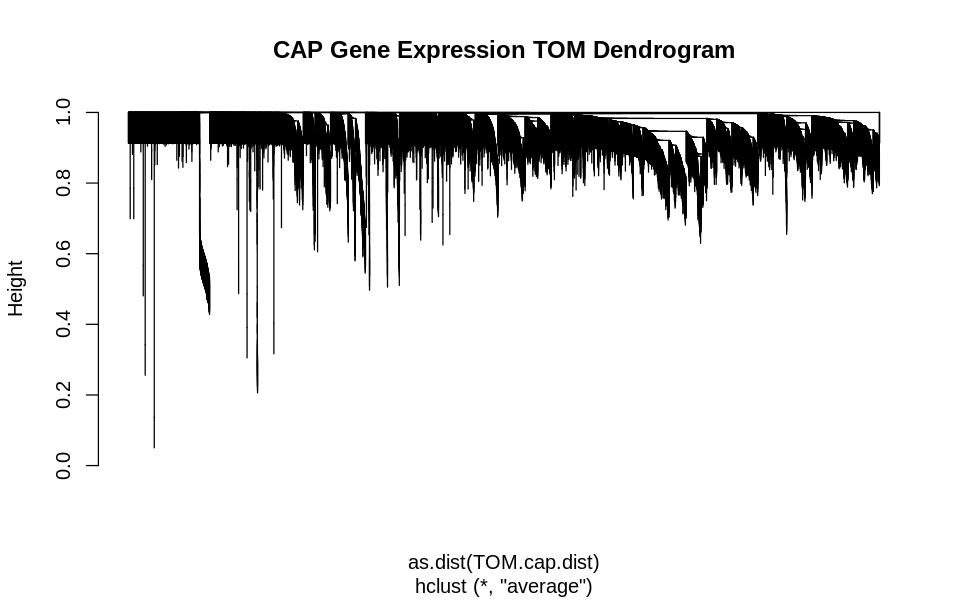

In [47]:
dendrogram = hclust(as.dist(TOM.cap.dist), method="average")

options(repr.plot.width=8, repr.plot.height=5)

plot(dendrogram, labels=FALSE, main="CAP Gene Expression TOM Dendrogram")

dynamic.mods.cap = cutreeDynamic(
  dendro=dendrogram, distM=TOM.cap.dist, pamRespectsDendro=FALSE,
  minClusterSize = 10
)
rm(TOM.cap.dist)

Here, I merge similar modules based on their module eigengenes. I am merging all modules with a distance of less than 0.1 (a correlation between module eigengenes of greater than 0.9)

In [48]:
me.data = moduleEigengenes(gene.exp.cap, colors=dynamic.mods.cap)
me = me.data$eigengenes
me.dist = 1 - cor(me, use="p", method="spearman")
me.tree = hclust(as.dist(me.dist), method="average")

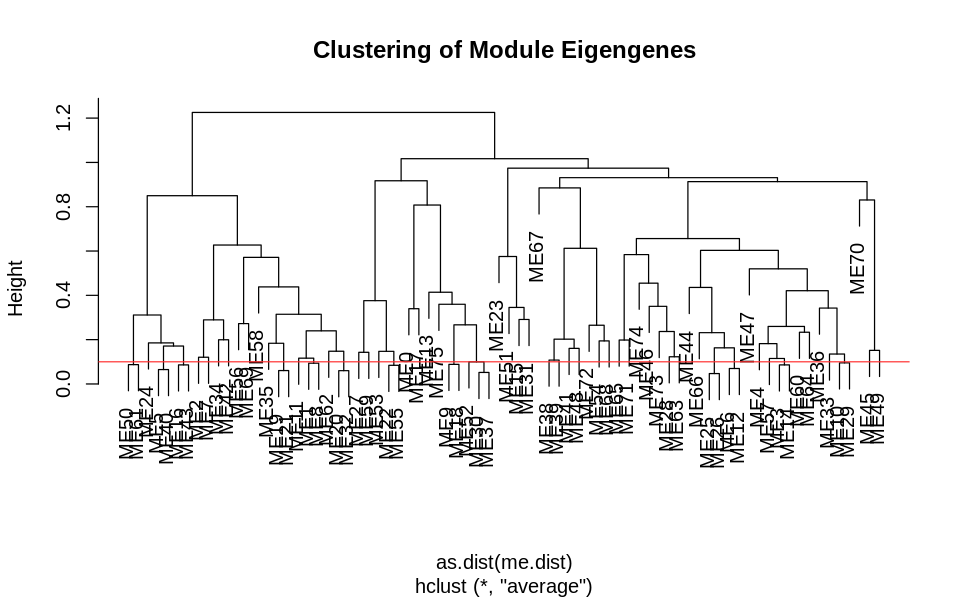

In [49]:
plot(me.tree, main="Clustering of Module Eigengenes")

me.dist.threshold = 0.1
abline(h=me.dist.threshold, col="firebrick1")

In [50]:
merge = mergeCloseModules(
    gene.exp.cap, 
    colors=dynamic.mods.cap, 
    cutHeight=me.dist.threshold,
    corOptions=list(use="p", method="spearman")
)
merge.mods.cap = merge$colors

 mergeCloseModules: Merging modules whose distance is less than 0.1
   Calculating new MEs...


The merged modules are not labeled by frequency. I refactor the module names to name them in decreasing order. The 0-th module represents unassigned genes and remains 0 regardless of the number of genes in the module.

In [51]:
merge.mods.no.zero = merge.mods.cap[merge.mods.cap != 0]

freq.mod.labels = 0:length(table(merge.mods.no.zero))
names(freq.mod.labels) = c("0", names(table(merge.mods.no.zero))[order(table(merge.mods.no.zero), decreasing=T)])

merge.mods.cap = as.numeric(as.character(plyr::revalue(factor(merge.mods.cap), replace=freq.mod.labels)))

In [52]:
table(merge.mods.cap)

merge.mods.cap
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
3604 2265 1267 1199 1002  902  844  812  752  734  481  426  415  413  383  375 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 361  297  279  223  221  202  199  170  158  154  135  135  133  120  120  108 
  32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47 
 100   95   89   82   77   77   76   73   71   70   66   62   61   61   58   55 
  48   49   50   51   52   53   54   55   56   57   58   59 
  43   40   40   36   35   31   27   25   24   20   18   11 

### Intra- and Inter-Module Connectivity

Connectivity is a measure assigned to each gene that describes how well the gene fits into a certain group of genes. Intra-module connectivity is a measure of how well the gene belongs to the module, Conversely, inter-module connectivity is a measure of how well the gene belongs to all other genes outside the module. Genes that are more "central" in the module will tend to have a high intra-module connectivity and a low inter-module connectivity.

In [53]:
connectivity.cap <- intramodularConnectivity(TOM.cap.matrix, colors=merge.mods.cap)
rownames(connectivity.cap) <- colnames(gene.exp.cap)

### Co-Expression Module Size Distribution

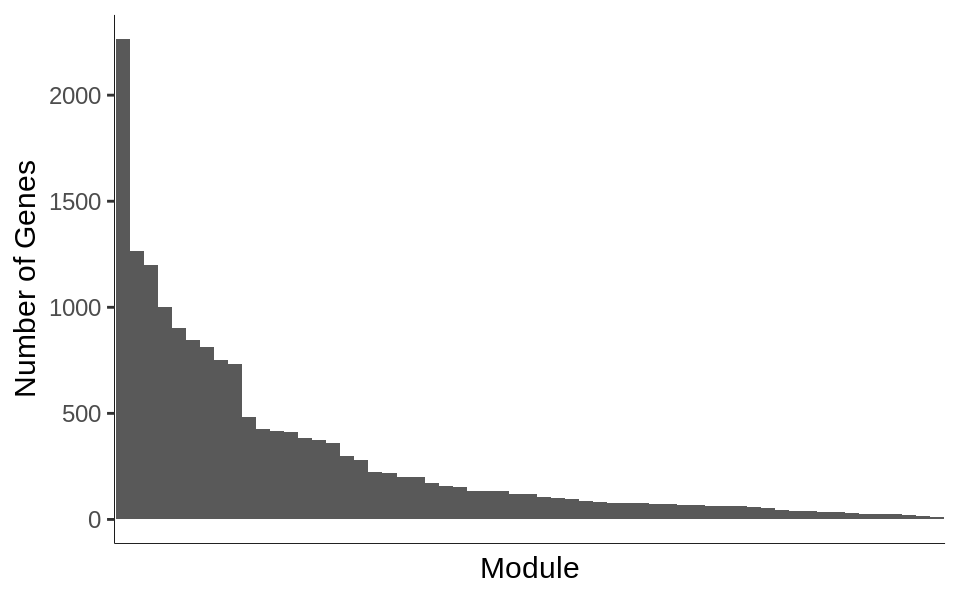

In [54]:
plot.data <- as.data.frame(table(merge.mods.cap)) %>%
  dplyr::select(Module=1, Frequency=Freq) %>%
  dplyr::filter(Module != 0)

options(repr.plot.width=8, repr.plot.height=5)

ggplot(plot.data) +
  geom_col(aes(x=Module, y=Frequency), width=1) +
  xlab("Module") + ylab("Number of Genes") +
  ggplot_theme +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())
ggsave(filename="04_Expression/results/gene_coexpression_module_sizes_cap.svg", width=8, height=5)

### Save Gene Co-Expression Modules

I save a the list of genes and their assigned modules, the eigengenes, the variance explained by each eigengene, and the connectivity information for each gene.

The modules are labelled `Module_1,Module_2,...`. `Module_0` contains genes that were not assigned to any co-expression module by WGCNA and are therefore labelled as `Unassigned`.

The eigengene of a given co-expression module is the first principal component of the gene expression for the genes within the module.

The variance explained by each eigengene tells us how well the eigengene captures the overall variation found within the module expression data.

In [55]:
### Module Assignment

gene.list <- colnames(gene.exp.cap)

mod.assignment <- merge.mods.cap
mod.labels <- paste0("Module_", mod.assignment)
mod.labels[mod.labels == "Module_0"] <- "Unassigned"

modules <- data.frame(
  Gene=gene.list,
  Module=mod.labels
) %>%
  dplyr::arrange(Module, Gene)

write.csv(modules, "~/gains_team282/nikhil/expression/gene_expression/modules.cap.csv", row.names=F)

### Eigengenes

eigengenes.result <- moduleEigengenes(gene.exp.cap[mod.labels != "Unassigned"], colors=mod.labels[mod.labels != "Unassigned"])
eigengene.order <- order(as.numeric(sapply(strsplit(colnames(eigengenes.result$eigengenes), "_"), function(x) x[2])))

eigengenes <- eigengenes.result$eigengenes
colnames(eigengenes) <- sapply(strsplit(colnames(eigengenes), "_"), function(x) paste0("ME_", x[2]))
eigengenes <- eigengenes[,eigengene.order]

rownames(eigengenes) <- rownames(gene.exp.cap)

write.csv(eigengenes, "~/gains_team282/nikhil/expression/gene_expression/eigengenes.cap.csv")

variance.explained <- data.frame(
  Module=colnames(eigengenes),
  Var.Explained=t(eigengenes.result$varExplained[eigengene.order])[,1]
)

write.csv(variance.explained, "~/gains_team282/nikhil/expression/gene_expression/variance.explained.cap.csv", row.names=F)

### Connectivity

connectivity <- connectivity.cap[modules$Gene,]
connectivity <- cbind(connectivity, modules$Module)
colnames(connectivity)[ncol(connectivity)] <- "Module"

write.csv(connectivity, "~/gains_team282/nikhil/expression/gene_expression/connectivity.cap.csv")

# Remove files used in CAP analysis to clear up space for FP analysis
rm(
  connectivity, connectivity.cap, dendrogram, eigengenes, eigengenes.result, 
  modules, plot.data, TOM.cap.matrix, variance.explained
)

## FP Individuals

The following analysis generates co-expression modules from gene expression from individuals with fecal peritonitis (FP).

### WGCNA Checks

The following function identifies genes with excessive missing values and outlier samples. It is generally more important for microarray data.

In [27]:
gsg <- goodSamplesGenes(gene.exp.fp)
gsg$allOK

 Flagging genes and samples with too many missing values...
  ..step 1


[1] TRUE

### Soft Threshold

The adjacency matrix generated using the correlation function does not fit a scale-free topology. A scaling function is used to generate the appropriate gene degree distribution. A parameter of this scaling function, $\beta$, is estimated by trying multiple values and checking how well the resulting network fits the assumptions of a scale-free network. Here, I try all integer values in $[1,20]$.

In [28]:
powers = seq(1, 20, by=1)

# Warning being suppressed - Pearson fallback used when MAD is zero in bicor
soft.thresholds = suppressWarnings(
    pickSoftThreshold(gene.exp.fp, powerVector=powers, networkType="unsigned", corFnc=bicor)
)
    
soft.threshold.fp = soft.thresholds$powerEstimate

   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1    0.132  0.587          0.927 3730.00  3.67e+03   6640
2      2    0.475 -0.783          0.920 1160.00  1.02e+03   3200
3      3    0.724 -1.260          0.929  480.00  3.67e+02   1910
4      4    0.779 -1.470          0.937  237.00  1.51e+02   1280
5      5    0.821 -1.550          0.956  132.00  6.86e+01    923
6      6    0.833 -1.620          0.957   80.00  3.34e+01    697
7      7    0.844 -1.650          0.961   51.90  1.72e+01    544
8      8    0.839 -1.670          0.960   35.40  9.13e+00    435
9      9    0.849 -1.650          0.962   25.20  5.06e+00    354
10    10    0.844 -1.650          0.951   18.50  2.85e+00    293
11    11    0.818 -1.640          0.923   14.00  1.64e+00    245
12    12    0.806 -1.600          0.896   10.90  9.59e-01    207
13    13    0.818 -1.510          0.871    8.63  5.77e-01    177
14    14    0.939 -1.350          0.948    6.97  3.54e-01    152
15    15    0.981 -1.310 

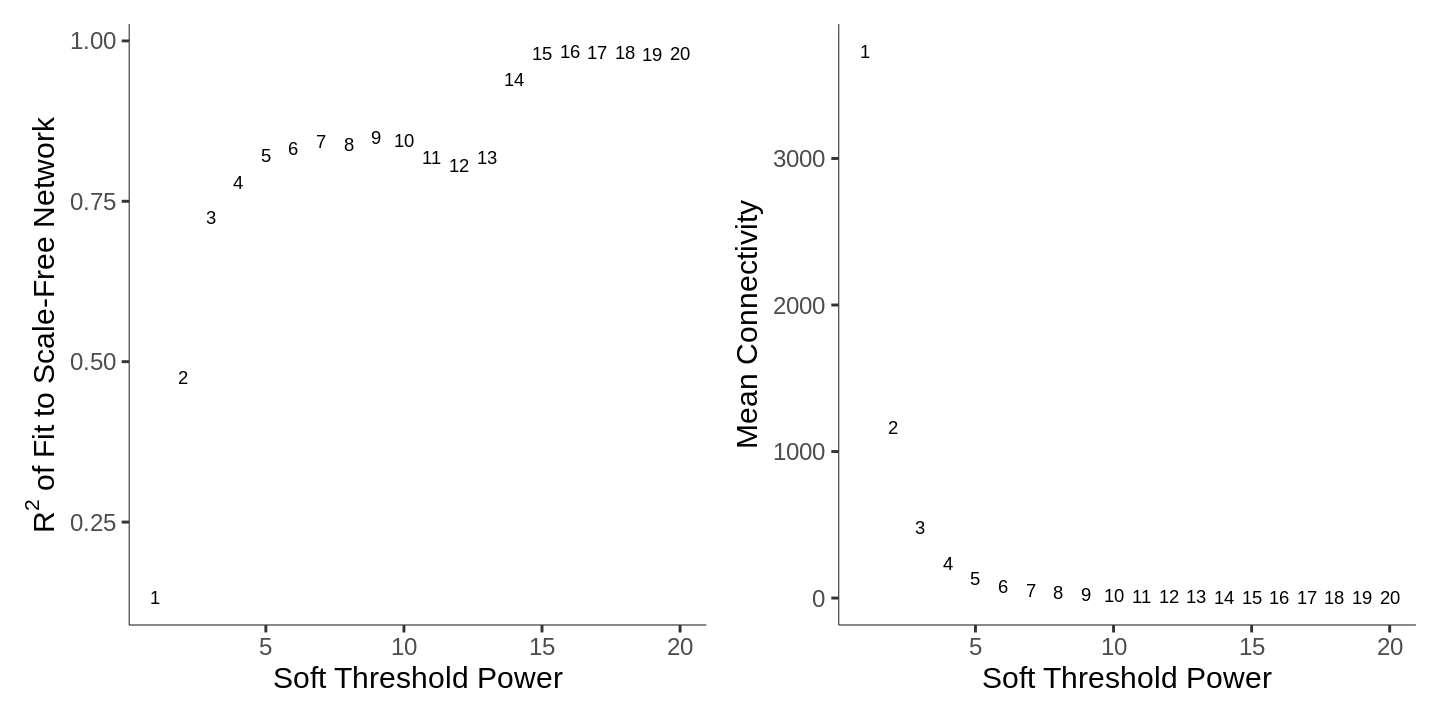

In [29]:
options(repr.plot.width=12, repr.plot.height=6)

p1 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=SFT.R.sq, label=Power)) +
    xlab("Soft Threshold Power") + ylab(bquote(R^2*" of Fit to Scale-Free Network")) +
    ggplot_theme

p2 <- soft.thresholds$fitIndices %>%
    ggplot() +
    geom_text(aes(x=Power, y=mean.k., label=Power)) +
    xlab("Soft Threshold Power") + ylab("Mean Connectivity") +
    ggplot_theme

p1 + p2

In [30]:
print(soft.threshold.fp)

[1] 14


### Adjacency and TOM Matrices

The adjacency matrix defines the similarity between all genes in the sample data. I am using the [biweight midcorrelation](https://en.wikipedia.org/wiki/Biweight_midcorrelation) (`bicor`) function to estimate similarity. It is a median-based approach that is less sensitive to outliers.

I use $\beta=14$ for the scaling function, which was determined in the previous step. Then, the topological overlap metric (TOM) matrix is generated from the adjacency matrix. For details, check the original WGCNA paper.

In [31]:
adjacency.matrix = adjacency(
    gene.exp.fp, type="unsigned", 
    corFnc=bicor, corOptions=list(use="pairwise.complete.obs", pearsonFallback="individual"), 
    power=soft.threshold.fp
)

TOM.fp.matrix = TOMsimilarity(adjacency.matrix)

dir.create("~/gains_team282/nikhil/expression/gene_expression/", recursive=TRUE)
saveRDS(TOM.fp.matrix, file="~/gains_team282/nikhil/expression/gene_expression/TOM.fp.matrix.RDS")

TOM.fp.dist = 1 - TOM.fp.matrix

Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


..connectivity..
..matrix multiplication (system BLAS)..
..normalization..
..done.


Warning message in dir.create("~/gains_team282/nikhil/expression/gene_expression/", :
“'/nfs/users/nfs_n/nm18/gains_team282/nikhil/expression/gene_expression' already exists”


### Clustering TOM Matrix

The gene co-expression modules are generated by clustering the TOM matrix.

 ..cutHeight not given, setting it to 0.999  ===>  99% of the (truncated) height range in dendro.
 ..done.


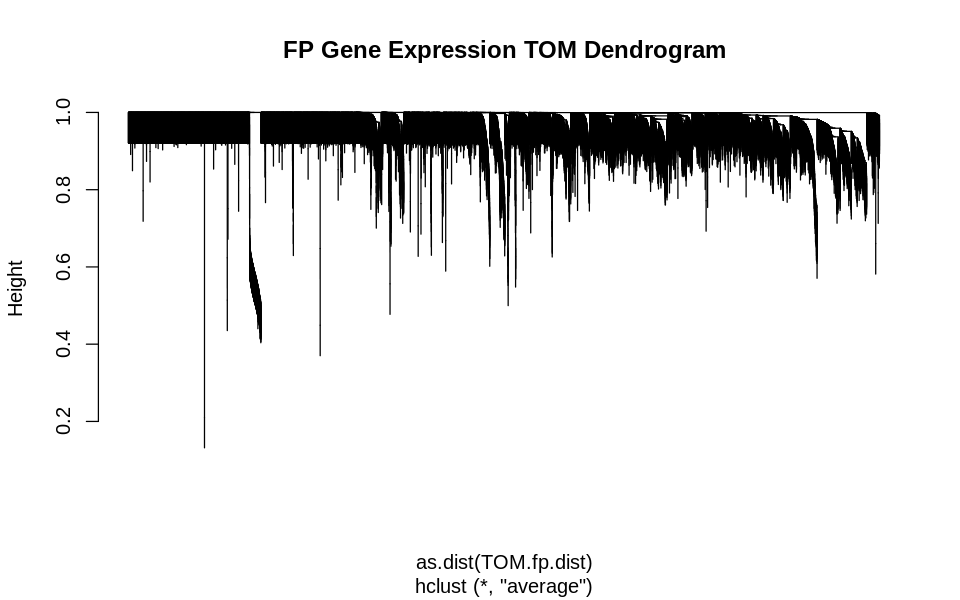

In [32]:
dendrogram = hclust(as.dist(TOM.fp.dist), method="average")

options(repr.plot.width=8, repr.plot.height=5)

plot(dendrogram, labels=FALSE, main="FP Gene Expression TOM Dendrogram")

dynamic.mods.fp = cutreeDynamic(
  dendro=dendrogram, distM=TOM.fp.dist, pamRespectsDendro=FALSE,
  minClusterSize = 10
)
rm(TOM.fp.dist)

Here, I merge similar modules based on their module eigengenes. I am merging all modules with a distance of less than 0.1 (a correlation between module eigengenes of greater than 0.9)

In [33]:
me.data = moduleEigengenes(gene.exp.fp, colors=dynamic.mods.fp)
me = me.data$eigengenes
me.dist = 1 - cor(me, use="p", method="spearman")
me.tree = hclust(as.dist(me.dist), method="average")

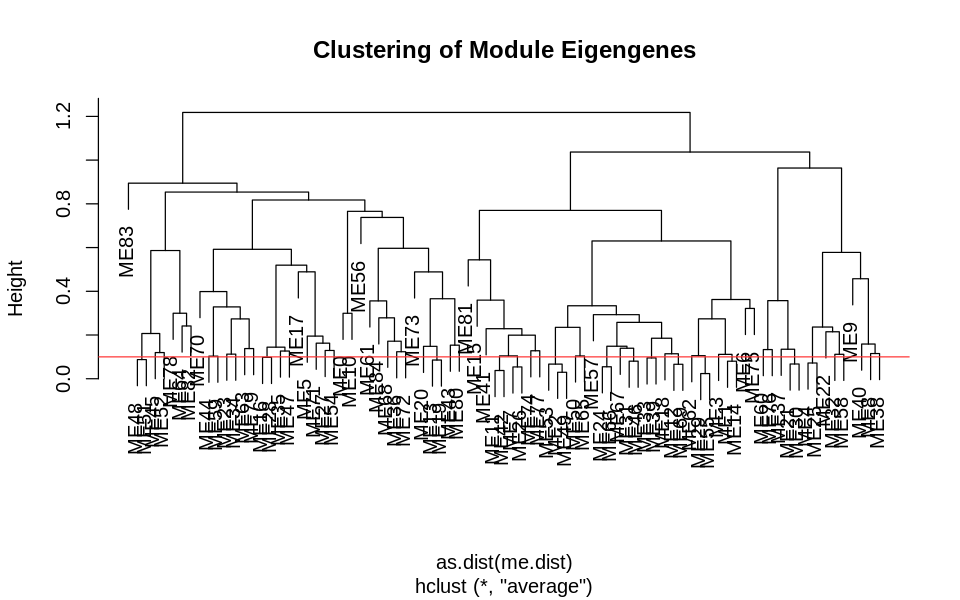

In [34]:
plot(me.tree, main="Clustering of Module Eigengenes")

me.dist.threshold = 0.1
abline(h=me.dist.threshold, col="firebrick1")

In [35]:
merge = mergeCloseModules(
    gene.exp.fp,
    colors=dynamic.mods.fp, 
    cutHeight=me.dist.threshold,
    corOptions=list(use="p", method="spearman")
)
merge.mods.fp = merge$colors

 mergeCloseModules: Merging modules whose distance is less than 0.1
   Calculating new MEs...


The merged modules are not labeled by frequency. I refactor the module names to name them in decreasing order. The 0-th module represents unassigned genes and remains 0 regardless of the number of genes in the module.

In [36]:
merge.mods.no.zero = merge.mods.fp[merge.mods.fp != 0]

freq.mod.labels = 0:length(table(merge.mods.no.zero))
names(freq.mod.labels) = c("0", names(table(merge.mods.no.zero))[order(table(merge.mods.no.zero), decreasing=T)])

merge.mods.fp = as.numeric(as.character(plyr::revalue(factor(merge.mods.fp), replace=freq.mod.labels)))

In [37]:
table(merge.mods.fp)

merge.mods.fp
   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
7316 1763 1131  917  759  602  548  425  422  400  347  344  334  318  292  282 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 273  229  222  212  194  182  176  145  124  120  117  110  109  107  105  104 
  32   33   34   35   36   37   38   39   40   41   42   43   44   45   46   47 
 102  101  101   96   89   83   82   74   73   73   66   62   61   56   55   44 
  48   49   50   51   52   53   54   55   56   57   58   59   60   61   62   63 
  41   38   36   36   36   35   33   30   29   24   23   22   18   17   17   15 
  64 
  15 

### Intra- and Inter-Module Connectivity

Connectivity is a measure assigned to each gene that describes how well the gene fits into a certain group of genes. Intra-module connectivity is a measure of how well the gene belongs to the module, Conversely, inter-module connectivity is a measure of how well the gene belongs to all other genes outside the module. Genes that are more "central" in the module will tend to have a high intra-module connectivity and a low inter-module connectivity.

In [39]:
connectivity.fp <- intramodularConnectivity(TOM.fp.matrix, colors=merge.mods.fp)
rownames(connectivity.fp) <- colnames(gene.exp.fp)

### Co-Expression Module Size Distribution

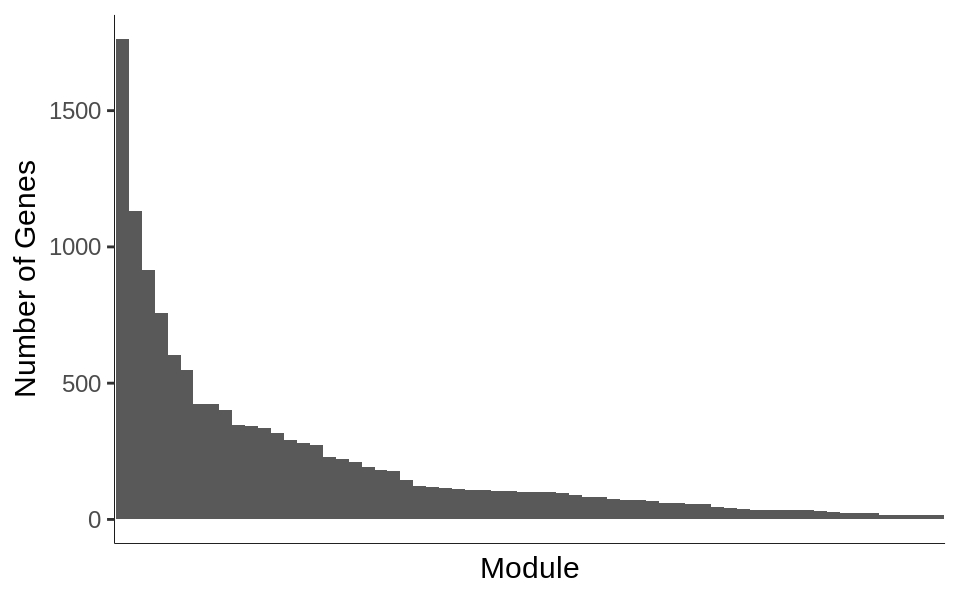

In [40]:
plot.data <- as.data.frame(table(merge.mods.fp)) %>%
  dplyr::select(Module=1, Frequency=Freq) %>%
  dplyr::filter(Module != 0)

options(repr.plot.width=8, repr.plot.height=5)

ggplot(plot.data) +
  geom_col(aes(x=Module, y=Frequency), width=1) +
  xlab("Module") + ylab("Number of Genes") +
  ggplot_theme +
  theme(axis.text.x=element_blank(), axis.ticks.x=element_blank())
ggsave(filename="04_Expression/results/gene_coexpression_module_sizes_fp.svg", width=8, height=5)

### Save Gene Co-Expression Modules

I save a the list of genes and their assigned modules, the eigengenes, the variance explained by each eigengene, and the connectivity information for each gene.

The modules are labelled `Module_1,Module_2,...`. `Module_0` contains genes that were not assigned to any co-expression module by WGCNA and are therefore labelled as `Unassigned`.

The eigengene of a given co-expression module is the first principal component of the gene expression for the genes within the module.

The variance explained by each eigengene tells us how well the eigengene captures the overall variation found within the module expression data.

In [41]:
### Module Assignment

gene.list <- colnames(gene.exp.fp)

mod.assignment <- merge.mods.fp
mod.labels <- paste0("Module_", mod.assignment)
mod.labels[mod.labels == "Module_0"] <- "Unassigned"

modules <- data.frame(
  Gene=gene.list,
  Module=mod.labels
) %>%
  dplyr::arrange(Module, Gene)

write.csv(modules, "~/gains_team282/nikhil/expression/gene_expression/modules.fp.csv", row.names=F)

### Eigengenes

eigengenes.result <- moduleEigengenes(gene.exp.fp[mod.labels != "Unassigned"], colors=mod.labels[mod.labels != "Unassigned"])
eigengene.order <- order(as.numeric(sapply(strsplit(colnames(eigengenes.result$eigengenes), "_"), function(x) x[2])))

eigengenes <- eigengenes.result$eigengenes
colnames(eigengenes) <- sapply(strsplit(colnames(eigengenes), "_"), function(x) paste0("ME_", x[2]))
eigengenes <- eigengenes[,eigengene.order]

rownames(eigengenes) <- rownames(gene.exp.fp)

write.csv(eigengenes, "~/gains_team282/nikhil/expression/gene_expression/eigengenes.fp.csv")

variance.explained <- data.frame(
  Module=colnames(eigengenes),
  Var.Explained=t(eigengenes.result$varExplained[eigengene.order])[,1]
)

write.csv(variance.explained, "~/gains_team282/nikhil/expression/gene_expression/variance.explained.fp.csv", row.names=F)

### Connectivity

connectivity <- connectivity.fp[modules$Gene,]
connectivity <- cbind(connectivity, modules$Module)
colnames(connectivity)[ncol(connectivity)] <- "Module"

write.csv(connectivity, "~/gains_team282/nikhil/expression/gene_expression/connectivity.fp.csv")